<h1>Chapter 7 - Interventions and Causal effects <br><sub>Online Gaming Case Study</sub>
</h1>

The notebook is a code companion to chapter 7 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/). View the [book resources](https://www.altdeep.ai/causalaibook) to see other tutorials and book-related links.

In [1]:
# This code works with the following library versions. Older or more recent versions may work as well.
#!pip install pyro-ppl==1.9.0
#!pip install pandas==2.2.1

This tutorial works through the online gaming case study in chapter 7. In this case study, you imagine you are a data scientist at an online role-playing game company. Your leadership wants to know if side-quest engagement (mini-objectives that are tangential to the game's primary objectives) is a driver of in-game purchases of virtual artifacts. If the answer is yes, the company will intervene in the game dynamics such that players engage in more side-quests.

We first do a naive correlation analysis on observational <i>observational data</i>. In contrast to <i>experimental data</i>, we call this "observational data" because it is logged observations of the natural behavior of players as they log in and play. First, we download the data and generate summary statistics.

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_obs.csv")
df.drop('User ID', axis=1).groupby(
    ["Side-quest Engagement"]
).agg(
    ['count', 'mean', 'std']
)

In-game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                482  111.609461  55.562334
low                                 518   73.096371  75.947688

We want to know if there is a significant difference in in-game purchases between players with high side-quest engagement and players with low side-quest engagement. Let's look at the difference in means between the two groups.

In [3]:
summary = df.drop('User ID', axis=1).groupby(
    ["Side-quest Engagement"]
).agg(
    ['count', 'mean', 'std']
)

m1, m2 = summary['In-game Purchases']['mean']
diff = m1 - m2
print(diff)

38.513089924542214


The difference is positive, but just to be rigorous, we run a simple statistical test for significance. The following test computes a z-score. We'll conclude the difference is significant if the z-score is more than two standard deviations from the mean (roughly close to a significance level of .05).

In [4]:
n1, n2 = summary['In-game Purchases']['count']
s1, s2 =  summary['In-game Purchases']['std']
pooled_std = (s1**2 / n1 + s2**2 / n2) **.5
z_score = diff / pooled_std
abs(z_score) > 2.

True

The difference is significant.

If you reported this result to your leadership, they might decide to modify the game to encourage more side-quest engagement. But this would be a mistake. To see why, we look at data from an experiment that randomly assigned players to a groups where one group was encouraged to have high side-quest engagement and the other group was encouraged to have lower engagement. Let's repeat the analysis with this data.

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_exp.csv")
summary = df.drop('User ID', axis=1).groupby(
    ["Side-quest Engagement"]
).agg(
    ['count', 'mean', 'std']
)
print(summary)
n1, n2 = summary['In-game Purchases']['count']
m1, m2 = summary['In-game Purchases']['mean']
diff = m1 - m2
print(f"Mean difference in in-game purchases across groups: {diff}")

s1, s2 =  summary['In-game Purchases']['std']
pooled_std = (s1**2 / n1 + s2**2 / n2) **.5
z_score = (m1 - m2) / pooled_std
abs(z_score) > 2.

                      In-game Purchases                      
                                  count       mean        std
Side-quest Engagement                                        
high                                500   92.99054  51.673631
low                                 500  131.38228  94.840705
Mean difference in in-game purchases across groups: -38.39174000000001


True

We still get a statistically different result, but the effect size is negative.

Obviously, experimental results are preferable to observational results. Statistical common sense tells us that correlation does not imply causality, and that the difference in group means reflects correlation in the observational study, and refects causation in the experimental study.

Experimental data is great, but it may not be readily available. Acquiring experimental data may be infeasible and when it is feasible, it has a cost. Even in cases when it is cheap and easy to run experiments, like in an online media company, there are still <i>opportunity costs</i> to running experiments -- see the book for discussion. 

Ideally, we could achieve the results we got with experimental data with only the observational data simply by incorporating some causal assumptions into that analysis. We do that next.

# Building a generative model for use in simulating the experiment with intervention.

Next, we assume the following causal DAG.

![online game DAG](images/online-game-dag.png)

Here, we introduce Guild Membership - whether a player belongs to a player guild - as a common cause of side-quest engagement and in-game purchases.

Next, we use Pyro to build a full causal generative model on the observational data. First, we'll download the full observational data inclusive of guild membership. We'll then use that data to estimate some parameters for this model.

In [6]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_full_obs.csv")     #A

First, we'll estimate the marginal distribution of guild membership.

In [7]:
membership_counts = df['Guild Membership'].value_counts()
dist_guild_membership = membership_counts / sum(membership_counts)
print(dist_guild_membership)

Guild Membership
nonmember    0.515
member       0.485
Name: count, dtype: float64


In [8]:
dist_guild_membership.member

0.485

Next, we calculate the probability distribution of side-quest engagement for guild members and nonmembers respectively. First we calculate the probability distribution of side-quest engagement level ("high" vs "low") given that a player is a member of a guild, then we calculate the probability distribution of side-quest engagement level given that a player is not a member of a guild.

In [9]:
member_subset = df[df['Guild Membership'] == 'member']
member_engagement_counts = member_subset['Side-quest Engagement'].value_counts()
dist_engagement_member = member_engagement_counts / sum(member_engagement_counts)
print(dist_engagement_member)

nonmember_subset = df[df['Guild Membership'] == 'nonmember']
nonmember_engagement_counts = nonmember_subset['Side-quest Engagement'].value_counts()
dist_engagement_nonmember = nonmember_engagement_counts / sum(nonmember_engagement_counts)
print(dist_engagement_nonmember)

Side-quest Engagement
high    0.797938
low     0.202062
Name: count, dtype: float64
Side-quest Engagement
low     0.815534
high    0.184466
Name: count, dtype: float64


Next, for each combination of guild membership and side-quest engagement, calculate the mean and standard deviation of in-game purchases.

In [19]:
# Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with low side-quest engagement.
purchase_dist_nonmember_low_engagement = df[
    (df['Guild Membership'] == 'nonmember') &
    (df['Side-quest Engagement'] == 'low')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1  
).agg(['mean', 'std'])
print(round(purchase_dist_nonmember_low_engagement, 2))
μ_nonmember_low_engagement = purchase_dist_nonmember_low_engagement['In-game Purchases']['mean']
σ_nonmember_low_engagement = purchase_dist_nonmember_low_engagement['In-game Purchases']['std']

# Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with high side-quest engagement.
purchase_dist_nonmember_high_engagement = df[
    (df['Guild Membership'] == 'nonmember') &
    (df['Side-quest Engagement'] == 'high')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1  
).agg(['mean', 'std'])
print(round(purchase_dist_nonmember_high_engagement, 2))
μ_nonmember_high_engagement = purchase_dist_nonmember_high_engagement['In-game Purchases']['mean']
σ_nonmember_high_engagement = purchase_dist_nonmember_high_engagement['In-game Purchases']['std']

# Estimate the sample mean and standard deviation of in-game purchases for guild-members with low side-quest engagement.
purchase_dist_member_low_engagement = df[
    (df['Guild Membership'] == 'member') &
    (df['Side-quest Engagement'] == 'low')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1  
).agg(['mean', 'std']) 
print(round(purchase_dist_member_low_engagement, 2))
μ_member_low_engagement = purchase_dist_member_low_engagement['In-game Purchases']['mean']
σ_member_low_engagement = purchase_dist_member_low_engagement['In-game Purchases']['std']


# Estimate the sample mean and standard deviation of in-game purchases for guild-members with high side-quest engagement.
purchase_dist_member_high_engagement = df[
    (df['Guild Membership'] == 'member') &
    (df['Side-quest Engagement'] == 'high')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1  
).agg(['mean', 'std']) 
print(round(purchase_dist_member_high_engagement, 2))
μ_member_high_engagement = purchase_dist_member_high_engagement['In-game Purchases']['mean']
σ_member_high_engagement = purchase_dist_member_high_engagement['In-game Purchases']['std']

      In-game Purchases
mean              37.95
std               23.80
      In-game Purchases
mean              54.92
std                4.92
      In-game Purchases
mean             223.71
std                5.30
      In-game Purchases
mean             125.53
std               53.44


We'll use these sample statistics as parameter values in a generative model on the causal DAG. For Guild Membership and Side-Quest engagement, we'll use the sample proportions to estimate Bernoulli parameters.

For in-game purchases, we use two canonical distributions; the normal distribution and [half-normal distribution](https://en.wikipedia.org/wiki/Half-normal_distribution). We'll use the normal distribution for every case except for non-guild-members with low side-quest engagement. In this case, because the low mean and large scale parameter means we'll generate many negative values.  In-game purchases of course cannot be negative. This is not a big deal. But unlike pgmpy, Pyro gives us tremendous parameteric flexibility, and this is a good reason to use that flexibility. So for unengaged non-guild-members I use the half-normal distribution.  Generating from the half-normal distribution is the same as generating from the normal, except any negative values will have their sign changed to positive.  Since this will happen only about 5.5% of the time with negative values close to zero, it adds minimal bias to the mean for this group.

In [11]:
import pyro
from torch import tensor
from pyro.distributions import Bernoulli, HalfNormal, Normal

def model():
    # Probability of being a guild member vs a non-member
    p_member = tensor(dist_guild_membership.member) 
    # Generate a guild membership value from a Bernoulli distribution, where a value 1.0 indicates a member.
    is_guild_member = pyro.sample(
        "Guild Membership",
        Bernoulli(p_member)
    )
    p_engaged = (tensor(dist_engagement_member.high)*is_guild_member +
                 tensor(dist_engagement_nonmember.high)*(1-is_guild_member))
    is_highly_engaged = pyro.sample(
        "Side-quest Engagement",
        Bernoulli(p_engaged)
    )
    # Use sample means as estimates of location parameters for in-game purchases
    μ = (
            μ_nonmember_low_engagement * (1-is_guild_member) * (1 - is_highly_engaged) +
            μ_nonmember_high_engagement * (1-is_guild_member) * (is_highly_engaged) +
            μ_member_low_engagement * (is_guild_member)   * (1 - is_highly_engaged) +  
            μ_member_high_engagement * (is_guild_member)   * (is_highly_engaged)
    )
    # Use sample standard devs as estimates of scale parameters for in-game purchases
    σ = (
            σ_nonmember_low_engagement * (1-is_guild_member) * (1 - is_highly_engaged) +
            σ_nonmember_high_engagement * (1-is_guild_member) * (is_highly_engaged) +
            σ_member_low_engagement * (is_guild_member)   * (1 - is_highly_engaged) +  
            σ_member_high_engagement * (is_guild_member)   * (is_highly_engaged)
    )
    if(is_guild_member == tensor(0.) and is_highly_engaged == tensor(0.)):
        in_game_purchases = pyro.sample( 
            "In-game Purchases", 
            HalfNormal(μ, σ) 
        ) 
    else: 
        in_game_purchases = pyro.sample("In-game Purchases", Normal(μ, σ))

    # Convert the variable values from tensors into the datatypes seen in the original data.
    guild_membership = "member" if is_guild_member else "nonmember"
    engagement = "high" if is_highly_engaged else "low"
    in_game_purchases = float(in_game_purchases)

    return guild_membership, engagement, in_game_purchases

We and use `pyro.render` to confirm that the generative model adheres to our causal DAG.

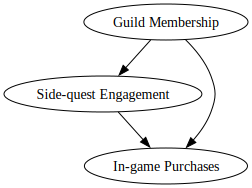

In [12]:
pyro.render_model(model)

Next, we can simulate tfrom the model and confirm that it has a distribution similar to the observational data. 

Let's look at the distribution of in-game purchases given side-quest engagement.

In [13]:
pyro.util.set_rng_seed(123)
simulated_observational_data = [model() for _ in range(1000)]    
sim_full_obs_df = pd.DataFrame(
    simulated_observational_data,
    columns=["Guild Membership", "Side-quest Engagement", "In-Game Purchases"]
)
sim_obs_df = sim_full_obs_df.drop("Guild Membership", axis=1)
sim_obs_df.groupby(["Side-quest Engagement"]).agg(['count', 'mean', 'std'])

In-Game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                486  116.672127  55.291171
low                                 514   60.642033  74.336396

We compare this to the observational distribution in the actual data.

In [14]:
df.drop(["Guild Membership", "User ID"], axis=1).groupby(["Side-quest Engagement"]).agg(['count', 'mean', 'std'])


In-game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                482  111.609461  55.562334
low                                 518   73.096371  75.947688

Next, we confirm that our model can simulate data similar to our experimental data. We do this by using Pyro's intervention operator `pyro.do`. We use `pyro.do` to create two models, one that sets engagement to high, the other to low.

In [15]:
# An intervention that sets Side-quest Engagement to 1.0 (i.e "high").  This returns a new model.
int_engaged_model = pyro.do(
    model,
    {"Side-quest Engagement": tensor(1.)}
)
# An intervention that sets Side-quest Engagement to 0.0 (i.e. "low").  This returns a new model.
int_unengaged_model = pyro.do(
    model,
    {"Side-quest Engagement": tensor(0.)}
)

Next, we simulate from both models and combine the results to get simulated experimental data.

In [16]:
# Setting a random seed for reproducibility. 
pyro.util.set_rng_seed(123)
# Simulate 500 rows from each intervention model and combined them to create simulated experimental data.
simulated_experimental_data = [
    int_engaged_model() for _ in range(500)
] + [
    int_unengaged_model() for _ in range(500)
]
simulated_experimental_data = pd.DataFrame(
    simulated_experimental_data,
    columns=[
        "Guild Membership", "Side-quest Engagement", "In-Game Purchases"
    ]
)
# The simulated data will include a Guild Membership column.  We can drop it to get simulated data that looks like the original experiment.
sim_exp_df = simulated_experimental_data.drop("Guild Membership", axis=1)
# Recreate the statistical summaries of in-game purchase for each level of engagement.
summary = sim_exp_df.groupby(
        ["Side-quest Engagement"]
    ).agg(
        ['count', 'mean', 'std']
    )
print(summary)

                      In-Game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                500   92.736599  52.817700
low                                 500  120.038426  98.760994


We see that this gives us a distribution similar to the actual experimental data.

In [17]:
exp_df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_exp.csv")

summary = exp_df.drop('User ID', axis=1).groupby(
        ["Side-quest Engagement"]
    ).agg(
        ['count', 'mean', 'std']
    )
print(summary)

                      In-game Purchases                      
                                  count       mean        std
Side-quest Engagement                                        
high                                500   92.99054  51.673631
low                                 500  131.38228  94.840705


In summary, we can use our observational data to train a causal model that can simulate experimental data. In other words, the causal model and its intervention operator allows us to "bootstrap" our observational data into experimental data. 